# Decision Tree Classifier

In [45]:
class DecisionTreeClassifierCustom:
    
    def __init__(self, max_depth = 6, min_samples_split=2, min_impurity_decrease=0.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.feature_importance = {}
        self.nodes = []
        
    def fit(self, data, features, target):
        self.n = len(data)
        self.features = features
        self.tree = self.__train_tree(data, features, target, max_depth=self.max_depth, 
                                      min_samples_split=self.min_samples_split, min_impurity_decrease=self.min_impurity_decrease)
        
    def predict(self, X):
        predictions = X.apply(lambda x: self.__predict(self.tree, x), axis=1)
        return np.array([pred[0] for pred in predictions])
    
    def predict_proba(self, X):
        predictions = X.apply(lambda x: self.__predict(self.tree, x), axis=1)
        return np.array([pred[1] for pred in predictions])
    
    def get_feature_importances(self):
        importance_data = dict.fromkeys(self.features, 0.0)
        first_node = self.nodes[0]
        
        for node in self.nodes:
            left = node["left"]
            right = node["right"]

            importance_data[node["splitting_feature"]] += (
                node["weighted_n_node_samples"] * node["impurity"] -
                left["weighted_n_node_samples"] * left["impurity"] -
                right["weighted_n_node_samples"] * right["impurity"]
            )

        importance_data_values = np.array(list(importance_data.values())) / first_node["weighted_n_node_samples"]
        norms = importance_data_values.sum()
        importance_data_values /= norms
        
        for i, key in enumerate(importance_data):
            importance_data[key] = importance_data_values[i]
    
        return sorted(importance_data.items(), key=lambda x: x[1], reverse=True)
   
    def __predict(self, tree, x):   
        if tree["is_leaf"]:
            return (tree["prediction"], tree["probability"])
        else:
            split_feature_value = x[tree['splitting_feature']]
            threshold =  tree["split_threshold"]
            if(threshold != None):
                if split_feature_value < threshold:
                    return self.__predict(tree["left"], x)
                else:
                    return self.__predict(tree["right"], x)
            else:
                if split_feature_value == 0:
                    return self.__predict(tree["left"], x)
                else:
                    return self.__predict(tree["right"], x)
    
    def ___reached_minimum_node_size(self, data, min_node_size):
        return len(data) <= min_node_size  
    
    def __intermediate_node_num_mistakes(self, labels_in_node):
        if len(labels_in_node) == 0:
            return 0

        num_of_first_class = (labels_in_node == 1).sum()
        num_of_second_class = (labels_in_node == 0).sum()
        
        return num_of_second_class if num_of_first_class > num_of_second_class else num_of_first_class

    def __create_node(self, splitting_feature, split_threshold, left_tree, right_tree, weighted_n_node_samples, impurity):
        return {"is_leaf"                 : False, 
                "prediction"              : None,
                "probability"             : None,
                "splitting_feature"       : splitting_feature,
                "split_threshold"         : split_threshold,
                "weighted_n_node_samples" : weighted_n_node_samples,
                "impurity"                : impurity,
                "left"                    : left_tree, 
                "right"                   : right_tree}
    
    def __calculate_gini(self, labels_in_node):
        if len(labels_in_node) == 0:
            return 0
        
        n = len(labels_in_node)
        
        num_of_first_class = (labels_in_node == 1).sum()
        num_of_second_class = (labels_in_node == 0).sum()
        
        majority_class = num_of_first_class if num_of_first_class > num_of_second_class else num_of_second_class
        
        p = majority_class / n
        
        # Simplifyed formula for 2 classes 
        gini = 2 * p * (1 - p) 
        return gini  
        
    def __create_leaf(self, target_values, weighted_n_node_samples, node_impurity):
        # Create a leaf node
        leaf = {"splitting_feature" : None,
                "weighted_n_node_samples": weighted_n_node_samples,
                "impurity": node_impurity,
                "left" : None,
                "right" : None,
                "is_leaf": True   }

        num_ones = len(target_values[target_values == 1])
        num_zeros = len(target_values[target_values == 0])
        
        if(len(target_values) > 0):
            leaf["probability"] = num_ones/(len(target_values))
        else: 
            leaf["probability"] = 0
        
        # For the leaf node, set the prediction to be the majority class.
        if num_ones > num_zeros:
            leaf["prediction"] = 1            
        else:
            leaf["prediction"] = 0
           

        return leaf     
        
    def __train_tree(self, data, features, target, current_depth = 0, max_depth = 6,
                     min_samples_split=10, min_impurity_decrease=-1):
    
        remaining_features = features[:]

        target_values = data[target]
        weighted_n_node_samples = len(data)/self.n
        node_impurity = self.__calculate_gini(target_values)
        
        print("--------------------------------------------------------------------")
        print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))

        # Stopping condition 1: All nodes are of the same type.
        if self.__intermediate_node_num_mistakes(target_values) == 0:
            print("Stopping condition 1 reached. All data points have the same target value.")
            return self.__create_leaf(target_values, weighted_n_node_samples, node_impurity)

        # Stopping condition 2: No more features to split on.
        if remaining_features == []:
            print("Stopping condition 2 reached. No remaining features.")
            return self.__create_leaf(target_values, weighted_n_node_samples, node_impurity)

        # Early stopping condition 1: Reached max depth limit.
        if current_depth >= max_depth:
            print("Early stopping condition 1 reached. Reached maximum depth.")
            return self.__create_leaf(target_values, weighted_n_node_samples, node_impurity)

        # Early stopping condition 2: Reached the minimum node size.
        if len(data) <= min_samples_split:  
            print("Early stopping condition 2 reached. Reached minimum node size.")
            return self.__create_leaf(target_values, weighted_n_node_samples, node_impurity)
        
        # Find the best splitting feature
        splitting_feature, feature_impurity, split_threshold = \
            self.__find_best_splitting_feature(data, features, target)
        
        left_split = data[data[splitting_feature] < split_threshold]
        right_split = data[data[splitting_feature] >= split_threshold]

        # Early stopping condition 3: Minimum impurity decrease
        impurity_after_split = feature_impurity
            
        if (node_impurity - impurity_after_split) <= min_impurity_decrease:
            print("Early stopping condition 3 reached. Minimum error reduction.")
            return self.__create_leaf(target_values, weighted_n_node_samples, node_impurity)

        remaining_features.remove(splitting_feature)
        print("Split on feature %s. (%s, %s)" % (\
                          splitting_feature, len(left_split), len(right_split)))

        # Recurse on left and right subtrees
        left_tree = self.__train_tree(left_split, remaining_features, target, 
                                         current_depth + 1, max_depth, min_samples_split, min_impurity_decrease)        

        right_tree = self.__train_tree(right_split, remaining_features, target, 
                                         current_depth + 1, max_depth, min_samples_split, min_impurity_decrease)


        node = self.__create_node(splitting_feature, split_threshold, left_tree, right_tree, weighted_n_node_samples, node_impurity)
        self.nodes.append(node)
        return node
    
    def __calculate_gini_and_get_best_split_threshold(self, data, feature, target):
        unique_inputs = data[feature].unique()
        
        N = len(data)
        best_gini = 10 # it's just stub, gini can be in range [0,1]
        best_threshold = None
        
        for val in unique_inputs:
            left_split = data[data[feature] < val]
            right_split = data[data[feature] >= val]
            
            n_L = len(left_split)
            n_R = len(right_split)

            gini_L = self.__calculate_gini(left_split[target])
            gini_R = self.__calculate_gini(right_split[target])

            gini_for_curent_val = (n_L / N) * gini_L + (n_R / N) * gini_R
            
            if(gini_for_curent_val < best_gini):
                best_threshold = val
                best_gini = gini_for_curent_val

        return (best_gini, best_threshold)
        
    def __find_best_splitting_feature(self, data, features, target):
        best_feature = None 
        best_split_threshold = None
        best_gini = 10      
        
        # Loop through each feature to consider splitting on that feature
        for feature in features:
            curent_feature_gini = None
            threshold = None
                
            curent_feature_gini, threshold = \
                self.__calculate_gini_and_get_best_split_threshold(data, feature, target)
            
            if curent_feature_gini < best_gini:
                best_feature = feature
                best_gini = curent_feature_gini
                best_split_threshold = threshold

        return [best_feature, best_gini, best_split_threshold]
    

## IMPORT LIBRARIES AND DATASET

In [2]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cardio_df = pd.read_csv("./data/cardio_train.csv", sep=";")

## EXPLORATORY DATA ANALYSIS AND DATA CLEANING 

In [4]:
cardio_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# Drop id
cardio_df = cardio_df.drop(columns = 'id')

In [6]:
# since the age is given in days, we convert it into years
cardio_df["age"] = cardio_df["age"]/365
cardio_df["age"] = cardio_df["age"].astype(int)

In [7]:
cardio_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
# checking the null values
cardio_df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [9]:
# Checking the dataframe information
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


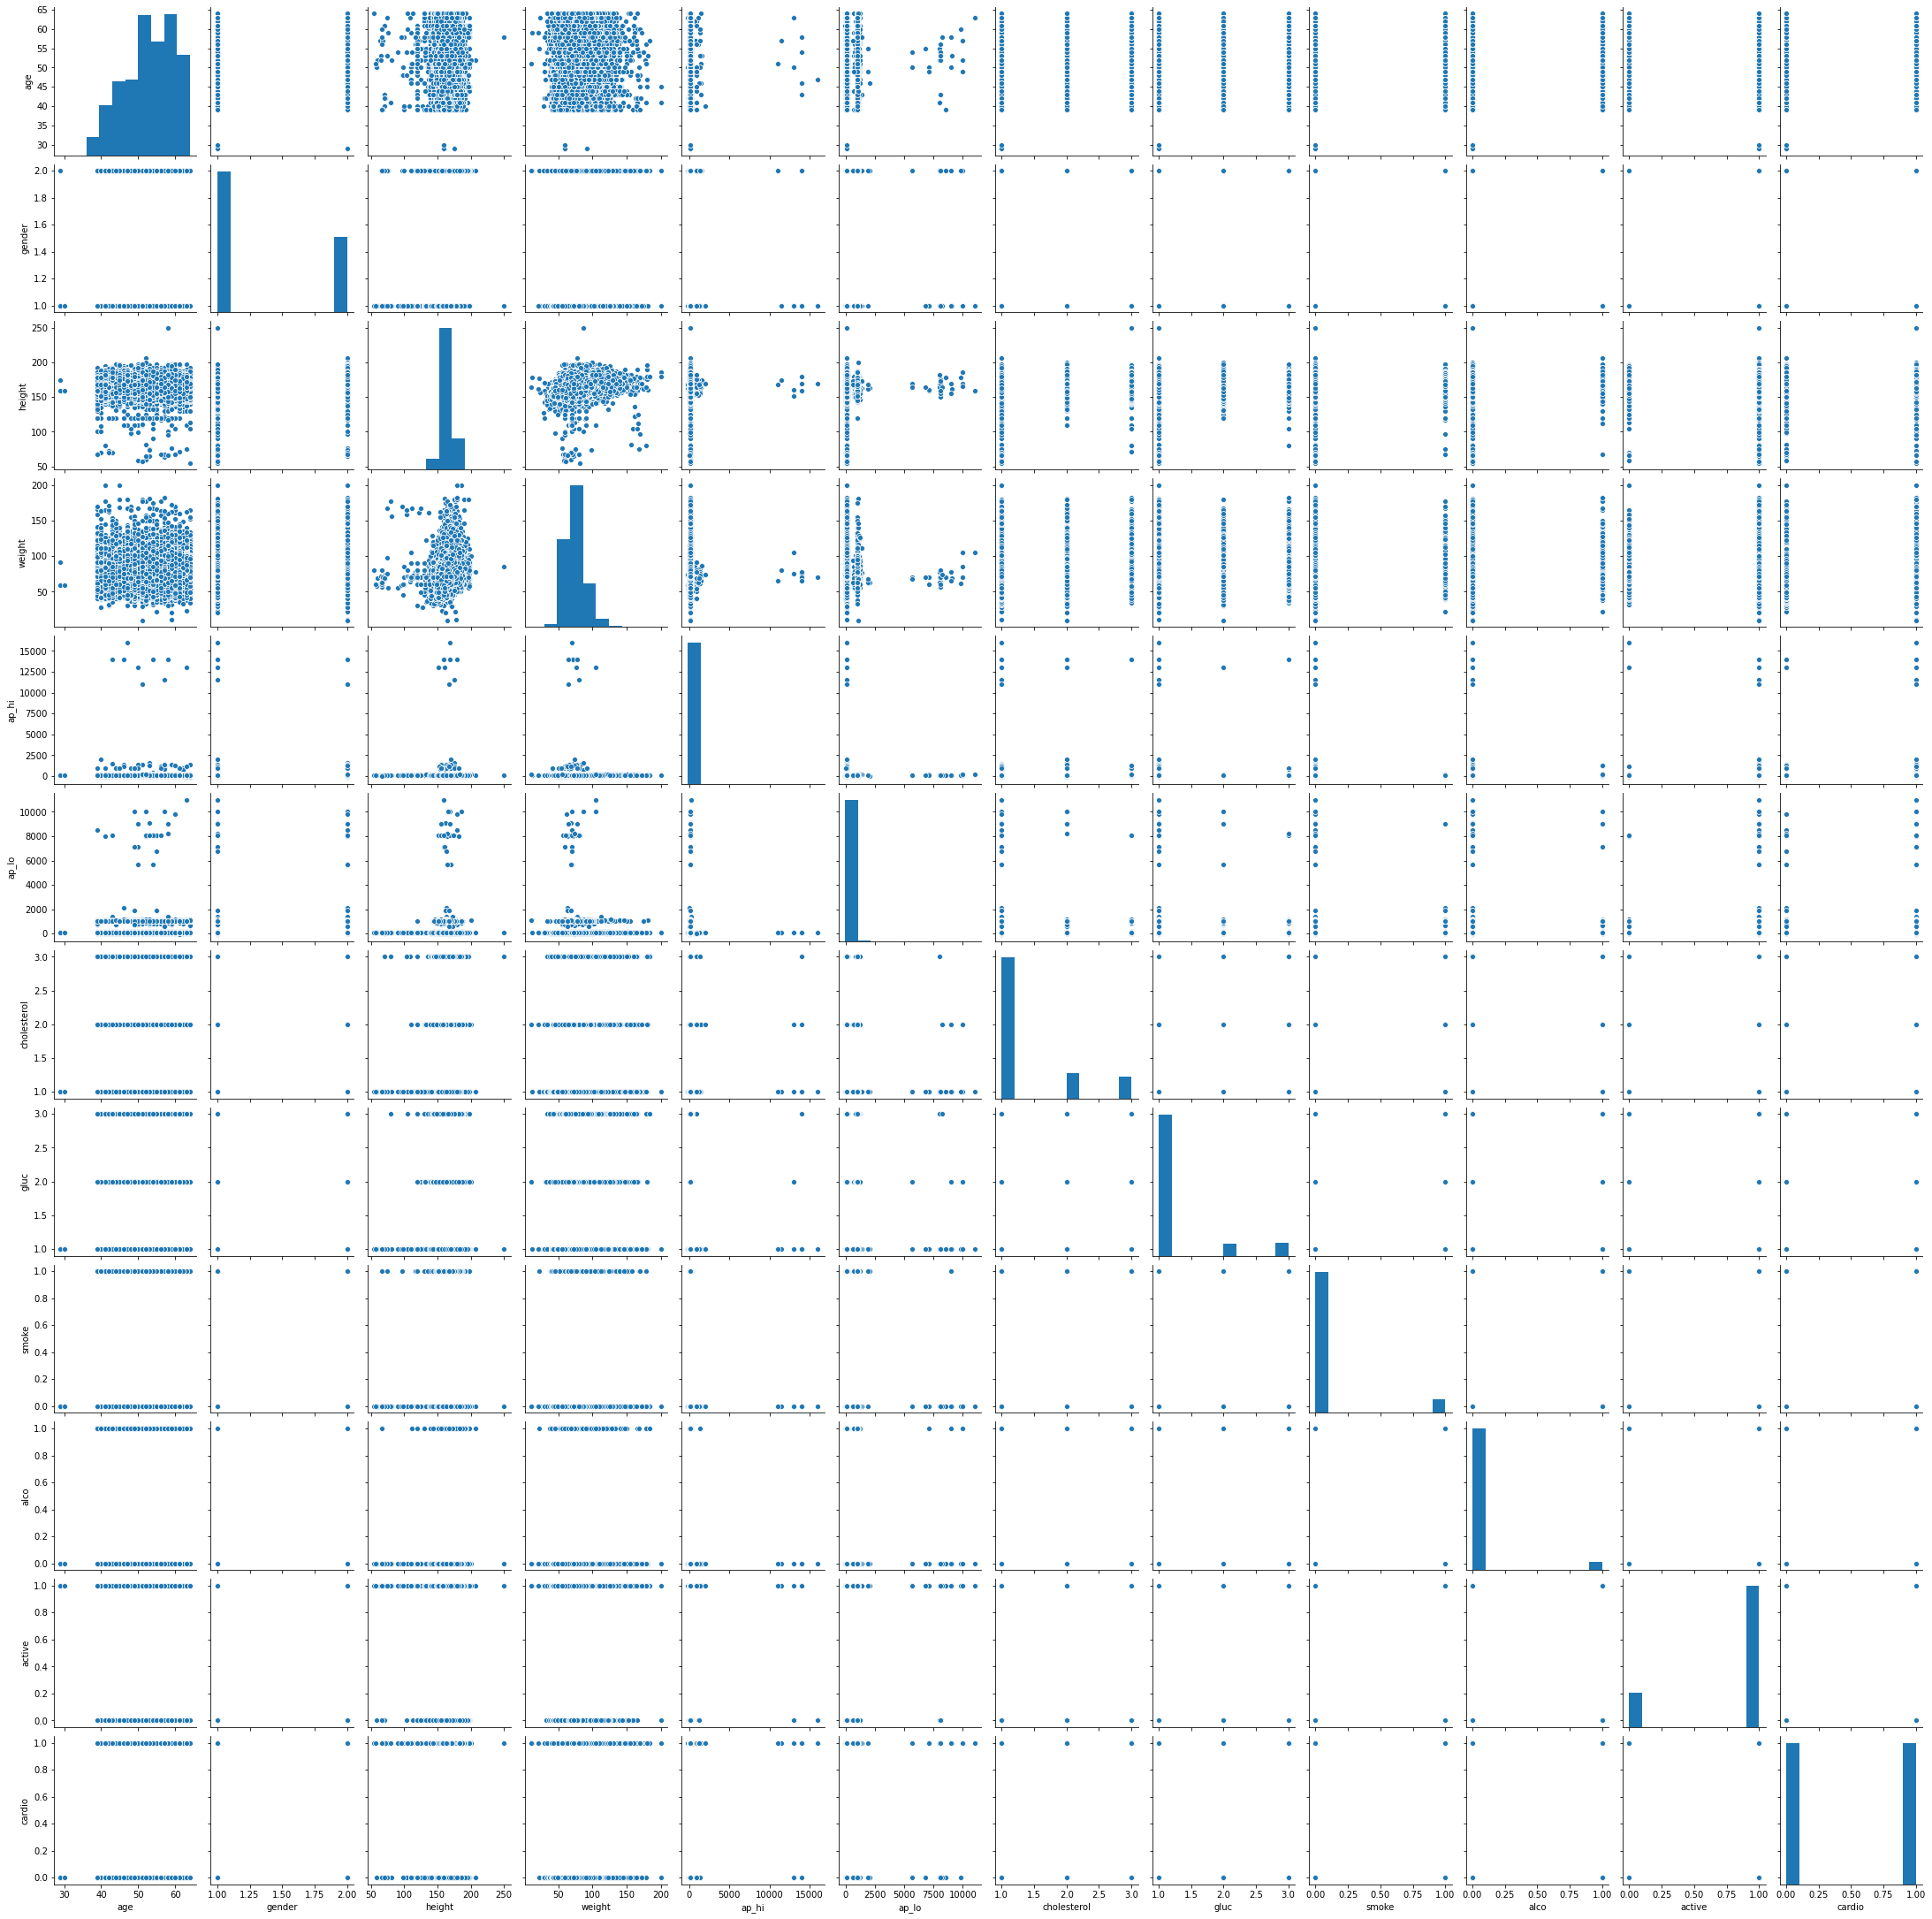

In [10]:
sns.pairplot(cardio_df)

## TRAIN  CUSTOM DESICION TREE AND SKLEARN DESICION TREE

In [46]:
# get feature names and target name 
features = list(cardio_df.columns)
features.remove("cardio")
target = "cardio"

In [47]:
# split into train and test datasets
train = cardio_df.sample(frac=0.8, random_state=0) 
test = cardio_df.drop(train.index)

In [48]:
custom_tree_model = DecisionTreeClassifierCustom(max_depth = 6)
custom_tree_model.fit(train, features, target)

--------------------------------------------------------------------
Subtree, depth = 0 (56000 data points).
Split on feature ap_hi. (33033, 22967)
--------------------------------------------------------------------
Subtree, depth = 1 (33033 data points).
Split on feature age. (20537, 12496)
--------------------------------------------------------------------
Subtree, depth = 2 (20537 data points).
Split on feature cholesterol. (19666, 871)
--------------------------------------------------------------------
Subtree, depth = 3 (19666 data points).
Split on feature weight. (6149, 13517)
--------------------------------------------------------------------
Subtree, depth = 4 (6149 data points).
Split on feature ap_lo. (2700, 3449)
--------------------------------------------------------------------
Subtree, depth = 5 (2700 data points).
Split on feature height. (2699, 1)
--------------------------------------------------------------------
Subtree, depth = 6 (2699 data points).
Early stop

Split on feature height. (53, 187)
--------------------------------------------------------------------
Subtree, depth = 6 (53 data points).
Early stopping condition 1 reached. Reached maximum depth.
--------------------------------------------------------------------
Subtree, depth = 6 (187 data points).
Early stopping condition 1 reached. Reached maximum depth.
--------------------------------------------------------------------
Subtree, depth = 4 (916 data points).
Split on feature height. (910, 6)
--------------------------------------------------------------------
Subtree, depth = 5 (910 data points).
Split on feature gluc. (505, 405)
--------------------------------------------------------------------
Subtree, depth = 6 (505 data points).
Early stopping condition 1 reached. Reached maximum depth.
--------------------------------------------------------------------
Subtree, depth = 6 (405 data points).
Early stopping condition 1 reached. Reached maximum depth.
--------------------

Split on feature gluc. (3599, 2124)
--------------------------------------------------------------------
Subtree, depth = 4 (3599 data points).
Split on feature age. (2244, 1355)
--------------------------------------------------------------------
Subtree, depth = 5 (2244 data points).
Split on feature height. (137, 2107)
--------------------------------------------------------------------
Subtree, depth = 6 (137 data points).
Early stopping condition 1 reached. Reached maximum depth.
--------------------------------------------------------------------
Subtree, depth = 6 (2107 data points).
Early stopping condition 1 reached. Reached maximum depth.
--------------------------------------------------------------------
Subtree, depth = 5 (1355 data points).
Split on feature height. (436, 919)
--------------------------------------------------------------------
Subtree, depth = 6 (436 data points).
Early stopping condition 1 reached. Reached maximum depth.
---------------------------------

In [49]:
from sklearn.tree import DecisionTreeClassifier
tree_model_sklearn = sklearn.tree.DecisionTreeClassifier(max_leaf_nodes=1000).fit(train.drop(target, axis=1), train[target])

## EVALUATE AND COMPARE CUSTOM TREE VS SKLEARN TREE ON TEST DATASET

In [50]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [51]:
## sklearn ROC AUC 
auc_sklearn = roc_auc_score(test[target], tree_model_sklearn.predict_proba(test[features])[:,1])
auc_custom = roc_auc_score(test[target], custom_tree_model.predict_proba(test))
accuracy_sklearn = accuracy_score(test[target], tree_model_sklearn.predict(test[features]))
accuracy_custom = accuracy_score(test[target], custom_tree_model.predict(test))

print("SKlearn model AUC on test:", auc_sklearn)
print("Custom model AUC on test:", auc_custom)
print("SKlearn model accuracy score on test", accuracy_sklearn)
print("Custom model accuracy score on test", accuracy_custom)

SKlearn model AUC on test: 0.7665186618338558
Custom model AUC on test: 0.777397496652952
SKlearn model accuracy score on test 0.7206428571428571
Custom model accuracy score on test 0.7290714285714286


In [32]:
## Custom Model Feature Importances
custom_tree_model.get_feature_importances()

[('ap_hi', 0.7447511562086757),
 ('age', 0.10211340094632473),
 ('cholesterol', 0.0701457549503163),
 ('ap_lo', 0.03627394886141822),
 ('weight', 0.019787534508185392),
 ('gluc', 0.009135804443064877),
 ('active', 0.0073537215997027845),
 ('height', 0.005036802479144785),
 ('smoke', 0.0032084099130047826),
 ('gender', 0.0014466175228922342),
 ('alco', 0.0007468485672701544)]

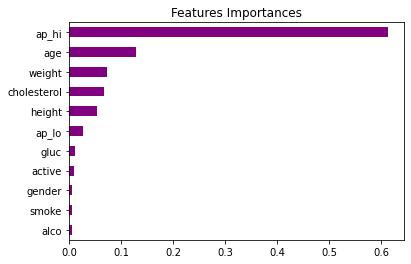

In [56]:
## SKlearn Model Feature Importances
importances = pd.Series(data=tree_model_sklearn.feature_importances_,
                        index=features)

importances_sorted = importances.sort_values()

importances_sorted.plot(kind='barh', color='purple')
plt.title('Features Importances')
plt.show()